#HODL: Session Graph Neural Networks

This session will introduce you to the basic concepts of graph neural networks. We will be using the popular deep learning framework pytorch and the graph specific PyG framework. This allows us to work with graphs using the same pytorch functionalities we have seen in the other lab sessions. However, we will first start with learning with sets instead of graphs as a warmup.

For todays session it's fine if we only use the cpu.

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Learning with Sets

Before we start with Graph Neural Networks, we zoom in on a related task: Learning functions on sets. A set is a collection of elements, where the order of the elements itself does not matter. The important thing is only wheter an element is part of the set or if it is not in the set.

For example lets look at the the following set $A = \{ h, o, d, l, i, s, g, r, e, a, t\}$

herer we have $o \in A$ but the element $x \notin A$.





In [ ]:
A = set('hodlisgreat')
print('o is in A?: ', 'o' in A)
print('x is in A?: ', 'x' in A)

Similarly, we can define the notion of a multiset. In a multiset we still do not care about the order of the elements (unlike in a vector). However, an element can now appear multiple times in the same multiset.

For example: the multiset $B = \{ d,i,a,m,o,n,d,h,a,n,d,s \}$ does contain the elements $a$ and $n$ which appear more than once.

In [ ]:
from multiset import *
B = Multiset('diamondhands')
print(B)

Is the multiset $ C = \{m,a,d,d,i,s,o,n,h,a,n,d\}$ the same set as B?

In [ ]:
#TODO create multiset C maddisonhand
C = Multiset([])

print('are the two multisets equal?', B == C)

But why do we care about sets and multisets?

Whenever we want to apply deep learning to some data, we must first represent the data as tensors. Now a naive way to represent sets as tensors would be to just write every element in one entry of the tensor. For example, we could write the set $S  = { 3, 2, 4, 1}$ as

In [ ]:
S = {3, 2, 4, 1}
torch_S = torch.tensor([3, 2, 4, 1])

However, the order of a set does not matter, so we could have also written S the following way.

In [ ]:
S2 = {1, 2, 3, 4}
# TODO: write the tensor representation of S2
torch_S2 = torch.tensor([1,2,3,4]) # = ...


In [ ]:
print("are the sets equal?", S == S2)
print("are the tensors equal?", torch.all(torch_S.eq(torch_S2)).item())

## Sets with MLPs

So the two sets are equal, however, their tensor representation is not!
This is very problematic if we want to use sets for learning a function. Then we want the function to always output the same value for the same set.  

Let's look at a simple task. Given a (multi)set of 11 numbers from 1 to 20. If more than half of the entries is above 10, we want to predict 1 and 0 otherwise.


In [ ]:
# Dataset creation
import numpy as np
def f(x):
  return 1.0 if (torch.sum(x > 10) - torch.sum(x <= 10)) > 0 else 0
np.random.seed(0)
dataset = [torch.tensor([np.random.randint(1,21) for i in range(11)]).float() for _ in range(1000)]
y = [torch.tensor(f(x)) for x in dataset]

We want to first solve it using our beloved MLP. Complete the training loop and model definitions in order to train an MLP for this task.

In [ ]:
def validate(model, val_loader,y_loader):
  model.eval()
  with torch.no_grad():
    acc = 0
    total = 0
    for i, data in enumerate(val_loader):
      data = data.float().to(device)
      pred = model(data)
      pred = pred.argmax()
      total += 1
      ground_truth = y_loader[i].item()
      # TODO: increase the count for correctly predicted items by 1
      acc += ground_truth == pred
    model.train()
  return (1.0*acc)/total

In [ ]:
import torch.optim as optim
from torch_geometric.loader import DataLoader

def train_model(model, dataset,y, epochs = 40, lr = 0.001):
  # define our loss and optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  val_split = 0.8
  train_size = int(val_split*len(dataset))
  train_loader = dataset[:train_size]
  val_loader = dataset[train_size:]
  y_loader = y[train_size:]

  # train the model
  model.train()

  for epoch in range(epochs):
      running_loss = 0.0
      for i, data in enumerate(train_loader):
          optimizer.zero_grad()

          data = data.float().to(device)
          # TODO: calculate the model predictions for the data
          pred = model(data)
          loss = criterion(pred, y[i].to(torch.long).to(device))
          loss.backward()

          optimizer.step()

          running_loss += loss.item()
      print(f'Epoch: {epoch + 1} loss: {running_loss / len(train_loader):.5f}\t validation acc: {validate(model, val_loader,y_loader)} train acc: {validate(model, train_loader,y)}')

      running_loss = 0.0

In [ ]:
#TODO: increase the dimension of the mlp
# dim = ...
dim = 256
model = torch.nn.Sequential(torch.nn.Linear(11, dim), torch.nn.ReLU(), torch.nn.Linear(dim, dim), torch.nn.ReLU(), torch.nn.Linear(dim, 2)).to(device)


train_model(model, dataset,y )

Hmm, we already have quite some difficulty training this model (you should expect to get around 70% accuracy). Why is this? What are we doing wrong?

Let's inspect the model predictions on the first 100 datapoints. We want to find a datapoint for which our predictions are correct and then reshuffle the entries and check if the prediction is still correct. Remember, for a set, the order of the elements does not matter, so the prediction should remain the same!

In [ ]:
model.eval()
for i in range(100):
  a = dataset[i].detach().clone().to(device)


  # TODO: get the model prediction (you can use argmax()), and the groundtruth value from y
  pred = model(a).argmax()
  groundtruth = y[i]

  # TODO: check if pred and groundtruth are the same, if not we want to skip
  if(pred != groundtruth):
    continue

  print("datapoint: ")
  print(a)

  print("ground truth is ", groundtruth)
  print("prediction is ", pred)


  # Let's check if reshuffling the tensor changes the prediction
  for x in range(100):

    a = a.cpu().numpy() 
    # TODO: do a random shuffle of a, you can call np.random.shuffle(x)
    np.random.shuffle(a)

    # cast it back to a torch tensor
    a = torch.tensor(a).float().to(device)


    #TODO: calculate the new model prediction for a
    new_pred = model(a).argmax()

    if new_pred != y[i].item():
      print("same multiset: ")
      print(a)
      print("model predicts ", new_pred.item())
      break
  break

The prediction actually changes if we reshuffle the tensor :/, this is something we do not want for our model. But maybe we can use a more elaborate architecture to handle this case.

## DeepSets

DeepSets are a particular architecture which is designed to be **permutation-invariant**, meaning the prediction does not change when we reshuffle (or permute) the inputs of the model. Whenever we want to learn something where the input is a set, we would desire our model to be **permutation-invariant**.

The idea behind DeepSets is relatively straightforward. First, we want to encode the elements of the set independently from each other. This gives us an embedding of each element. Then in the second step, we want to combine all of these embeddings to get an embedding of the whole set. This combination step is also reffered to as an **aggregation**. Now why should this be permutation-invariant?

We can choose the aggregation step in a careful way to be invariant of the order. One of the most common operations for combining the element embeddings to a single set embedding is to take the sum. And because addition commutes (i.e. a+b = b+a), the sum of the vectors will always be the same, irregardless of the order.

Let's look at a step by step example. To encode the elements into vectors, we use a linear layer.

In [ ]:
S = torch.tensor([1,2,3,4]).reshape((4,1)).float()
S2 = torch.tensor([3,2,4,1]).reshape((4,1)).float()

enc_dim = 3
encode_elements = torch.nn.Linear(1, enc_dim)

elements_S = []
elements_S2 = []

for element in S:
  #TODO: encode element
  element = encode_elements(element)
  elements_S.append(element)

for element in S2:
  #TODO: encode element
  element = encode_elements(element)
  elements_S2.append(element)

print(elements_S)
print(elements_S2)

Now we want to compute the embedding of the whole set. We have to sum up all the vectors in elements_S and elements_S2 respectively.

In [ ]:
sum_S = torch.zeros(enc_dim)
sum_S2 = torch.zeros(enc_dim)


#TODO calculate the sum, and go over each element
# ...

for x in elements_S:
    sum_S += x

for x in elements_S2:
    sum_S2 += x

print(sum_S)
print(sum_S2)

also compute the embedding for S3, ...
is the embedding different? the same?

In [ ]:
S3 = torch.tensor([4,5,2,1]).reshape((4,1)).float()
# todo calculate the embedding for S3
elements_S3 = []
for element in S3:
    element = encode_elements(element)
    elements_S3.append(element)

print(elements_S3)
print(sum(elements_S3))

Now that we are familiar with the concept of learning with Sets using DeepSet, let's tackle the task from before again. Complete the missing lines.

In [ ]:
class DeepSet(torch.nn.Module):

    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()

        # TODO: specify two MLPs, one for the encoding part and for calculating the output

        self.encode   = torch.nn.Sequential(torch.nn.Linear(1,embedding_dim),
                                            torch.nn.Linear(embedding_dim,embedding_dim),
                                            torch.nn.Linear(embedding_dim,embedding_dim))
        # specify an MLP with 3 linear layers (1,embedding_dim)(embedding_dim,embedding_dim),(embedding_dim,embedding_dim) with ReLU activations in between
        self.deepset = torch.nn.Sequential(torch.nn.Linear(embedding_dim,hidden_dim),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(hidden_dim,hidden_dim),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(hidden_dim,hidden_dim))

     
    # specify an MLP with 3 linear layers (embedding_dim,hidden_dim)(hidden_dim,hidden_dim),(hidden_dim,hidden_dim) with ReLU activations in between

    def forward(self, data):

        # TODO: we need to reshape our data from (1, 11) to (11, 1), you can reshape a tensor x by calling x.reshape((a,b))
        # this allows us to apply the MLP elementwise for each entry in data
        data = torch.unsqueeze(data,0)
        x , y = data.shape
        data = data.reshape(y,x)

        # encodings = ... # apply the encode MLP
        encodings = self.encode(data)
        # encodings = ... # sum up the different embeddings to a single vector, you can call x.sum(dim=) where dim must be -1 or 0
        encodings = encodings.sum(dim=0)
      

        # pred = ... # apply the deepset MLP()
        pred = self.deepset(encodings)
        

        return pred



In [ ]:
import random
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

edim = 16
ddim = 256

#TODO: create the DeepSet model with the right dimensions
model = DeepSet(edim,ddim).to(device)

train_model(model,dataset,y ,epochs = 40)

Now let's check again if our predictions are more robust for sets.

In [ ]:
model.eval()
for i in range(100):

  # find a datapoint where the prediction is correct
  a = dataset[i].detach().clone().to(device)
  if int(y[i].item()) != int(model(a).argmax().item()):
    continue

  print("datapoint: ")
  print(a)

  print("ground truth is ", y[i].item())
  print("prediction is ", model(a).argmax().item())

  for x in range(100):
    np.random.shuffle(a.cpu().numpy())
    a = torch.tensor(a).float().to(device)
    pred = model(a)

    new_pred = pred.argmax()
    if new_pred != y[i].item():
      print("same multiset: ")
      print(a)
      print("model predicts ", new_pred.item())
      break
  else:
    print("found no counter example")
  break

Very well!

We have seen that using an architecture such as DeepSet we can learn with sets and do our computations in a **permutation-invariant** way so the order of the elements does not matter. You will see that when we do computations in graphs this trick will be very vital to successful learning on graphs.

# Graphs
Because this notebook is all about graphs, lets do a quick refresher on the most important graph terms.
Informally speaking, you can think of a graph as some points that are connected through lines between them.
A bit more formal, a graph $G$ is defined as a set of nodes $V$ and edges $E$ (Note, we already want to use sets at some point). An edge $e \in E$ is given by two nodes that it connects, i.e. $e = (u,v)$, connects the node $u$ with node $v$. Whenever we talk about graphs, we usually talk about _undirected_ graphs. In an undirected graph every edge $e$ is bidirectional, meaning it can be traversed in both directions.

We want to quickly go over the most important graph termonology.

* ***Node***: part of the graph, sometimes also called vertex
* ***Edge***: connects two nodes
* **Neighborhood**: the nodes that have distance 1 from you, i.e. $N(u)$ are all neighbors of node $u$.
* **Degree**: The number of edges incident to a node
* **r-hop neighborhood** all nodes that have at most distance $r$ from a node.
* **cycle**: a path that starts at $u$ and ends at $u$.



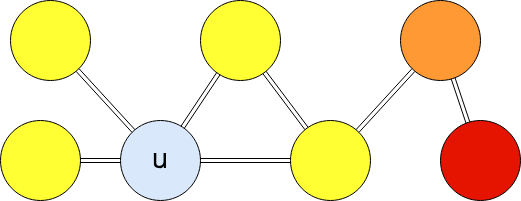

There are 7 nodes and 7 edges in the graph.

The neighborhood of $u$ consists of the yellow nodes.
Node $u$ has degree 4.
And the $2$-hop neighborhood of $u$ consists of the yellow and orange nodes.

There is one cycle in the graph, where you can start at $u$, visit a yellow node, visit the second yellow node and go back to $u$ again. Sometimes we also refer to this as a triangle (=cycle of length 3)

### Graph Representation

A key question is how do we represent graphs. One of the most common ways to represent them are using an adjecency matrix $A$. Each entry $a_{ij}$ of the adjecency matrix indicates if node $i$ and $j$ are connected.

Let's have a look at an example graph.
To work with graphs, we can use the popular library called networkx. Using this library we can easily define a graph, modify it, draw it and compute metrics such as shortest paths on them. If you want to do something specific on the graph, most likely there is a way to easily do it with some networkx function.



In [ ]:
import networkx as nx
import numpy as np

# Build a graph using an adjecency matrix A

A = np.array([[0, 1, 0],
              [1, 0, 1],
              [0, 1, 0]])

# using nx.from_numpy_array we can convert the adjecency matrix to a graph for networkx
G = nx.from_numpy_array(A)


An advantage of working with networkx is that we can easily draw and inspect the graphs we define using the built in draw function.

In [ ]:
nx.draw(G)

Can you change the adjecency matrix A so that the graph G will be a triangle instead?

In [ ]:
# TODO: modify the matrix A, so that G will be a triangle.
A_triang = np.array([[0, 1, 1],
                    [1, 0, 1],
                    [1, 1, 0]])

G_triang = nx.from_numpy_array(A_triang)
nx.draw(G_triang)
if nx.triangles(G_triang,0) == 0:
  print("There is no triangle!")
else:
  print("Yes, finally I have become a triangle graph.")

You can also use the networkx way of building a graph.

In [ ]:
import networkx as nx

# create a networkx graph
G2 = nx.Graph()

# add an edge between nodes 0, 1 ....
G2.add_edge(0,1)
G2.add_edge(1,2)
G2.add_edge(1,3)
G2.add_edge(3,4)
G2.add_edge(3,5)

nx.draw(G2)

In [ ]:
import networkx as nx

G = nx.Graph()
G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(3,4)
G.add_edge(3,5)

G.add_edge(6,7)
G.add_edge(7,8)
G.add_edge(8,9)
G.add_edge(9,6)

G.add_edge(10,11)
G.add_edge(11,12)
G.add_edge(12,10)

# TODO: add the 'L' for HODL add 3 nodes 13,14,15 to the graph to make the L
# G.add ....
G.add_edge(13,14)
G.add_edge(14,15)


{0: (0,0)}

pos = {0: (0,1),1: (0,0),2: (0,-1),3: (1,0),4: (1,1),5: (1,-1),
       6: (2,-1),7: (3,-1),8: (3,1),9: (2,1),
       10: (4,-1),11: (4,1),12: (5,0),
       13: (6,1),14: (6,-1),15: (7,-1)}

nx.draw(G, pos = pos)

Can you define a graph that consist of 4 nodes and 4 eges that build a cycle the "networkx way"?

In [ ]:
# create a networkx graph
G3 = nx.Graph()

# add the edges to complete the cycle
G3.add_edge(0,1)
# ... TODO: add more edges
G3.add_edge(1,2)
G3.add_edge(2,3)
G3.add_edge(3,0)

nx.draw(G3)

There exist also other ways to represent the graph.

A popular choice is the **adjecency list**.
Instead of having an entry for each individual edge (as in the adjecency matrix) we store for each node $u$ all its neighbors in a list.

In [ ]:
# Convert between different graph representations.
print(G)
nx.draw(G)
# Get the adjecency list of graph G
adj_list = nx.to_dict_of_lists(G)
for node in adj_list:
  print(f"node {node} is connected to: {adj_list[node]}")

Another way would be to instead just keep a list of edges that are present in the graph. This is the way pytorch geometric stores the graphs and how we will work with them when we use graph neural networks. From now on, we will refer to this representation as the **edge index**.

But don't worry you don't have to convert between all these different graph representations yourself.
Networkx to the rescue! We can easily convert from one representation to the other.

In [ ]:
# Convert between different graph representations
from torch_geometric.utils.convert import to_networkx, from_networkx

print(G)
nx.draw(G)

# to go from a networkx to a 'torch' graph we can use from_networkx
# TODO: call from_networkx() to build the torch graph
# torch_graph = ....
torch_graph = from_networkx(G)

#print(torch_graph)
# this returns a torch data object, to get the edge index, we can call
print(torch_graph.edge_index)

for i in range(torch_graph.edge_index.shape[1]):
  a = torch_graph.edge_index[0][i]
  b = torch_graph.edge_index[1][i]
  print(f"edge {i} is from {a} to {b}")


Note that the edge_index is a tensor! It is of shape (2, x) where x is the number of edges in the graph. By default, pytorch expects the graphs to be directed, meaning that an edge always goes from a to b. Therefore, each of our undirected edges has to have 2 edge entries.

In [ ]:
print(torch_graph.edge_index.shape)

small exercise: can you complete the edge index to get back an undirected triangle?

In [ ]:
tG = torch_graph.clone()

#TODO: adjust the edge index to include the additional edge to complete the triangle, remember to include the edge in both directions!
tG.edge_index = torch.tensor([
              [0, 1, 1, 2, 2, 0], # add edge
              [1, 0, 2, 1, 0, 2]
          ])
# convert the torch object to networkx
networkx_tG = to_networkx(tG).to_undirected(True)

# draw and check if it is a triangle
nx.draw(networkx_tG)
if nx.triangles(networkx_tG,0) == 0:
  print("There is no triangle!")
else:
  print("Yes, finally I have become a triangle graph.")

Note that whenever we refer to a single node, we usually give it a number (sometimes also called ID). How we assign these numbers is up to us. We can choose different assingments of the nodes to their IDs, but the underlying graph is still the same.

Unfortunately, if we only look at the graph representation it is hard to figure out if two graphs are actually the same graph!
To figure out if two graphs are the same is known as the [graph isomorphism problem](https://en.wikipedia.org/wiki/Graph_isomorphism_problem) and is an open problem.

Let's look at the two graph respresentations of graph_A and graph_B. Their matrix representation is different. But are they different graphs?

In [ ]:
graph_A = np.array([
    [0., 1., 0., 0., 0., 0.],
    [1., 0., 1., 1., 0., 0.],
    [0., 1., 0., 0., 0., 0.],
    [0., 1., 0., 0., 1., 1.],
    [0., 0., 0., 1., 0., 0.],
    [0., 0., 0., 1., 0., 0.]])

graph_B = np.array([
    [0., 0, 1, 0., 0., 0.],
    [0., 0, 1, 0., 0., 0.],
    [1., 1, 0, 1., 0., 0.],
    [0., 0, 1, 0., 1., 1.],
    [0., 0., 0., 1., 0., 0.],
    [0., 0., 0., 1., 0., 0.]])

print("Matrix of graph_A\n", graph_A)
print("Matrix of graph_B\n", graph_B)

print("Are the matrices the same: ", np.array_equal(graph_A, graph_B))



We can inspect the graphs when we draw them. What do you think, are they the same graphs or not?

In [ ]:
import matplotlib.pyplot as plt

# convert the graphs to networx
g_A = nx.from_numpy_array(graph_A)
g_B = nx.from_numpy_array(graph_B)

#TODO: draw both graphs in order to compare them

print("Draw Graph A")
# ... draw A
nx.draw(g_A)
plt.show()
print("Draw Graph B")
# ... draw B
nx.draw(g_B)
plt.show()

## Graph Generation and Processing

For certain tasks we might want to test on a synthetic dataset that we generate ourself in order to test how our models work on different classes of graphs.  

In other cases, we can work with a graph dataset that is given to us. However, maybe we still want to add some additional features or want to preprocess and remove certain nodes.

This section is all about how to generate and/or prepare the graph data properly so that we can work, learn and train models with them.





In [ ]:
import networkx as nx

# define a class to generate graphs
class Trees():
    def __init__(self):
        super().__init__()


    # we call this to generate a graph with a certain number of nodes
    def gen_graph(self, num_nodes, num):

        # we can use networkx to generate us a random tree
        nx_graph = nx.random_labeled_tree(n=num_nodes, seed=num)

        # convert the nx representation to something torch understands
        # TODO: convert the networkx graph to pytorch graph as seen before
        # tree = ...
        tree = from_networkx(nx_graph)

        return tree

    # we call this to generate a dataset
    def makedata(self, num_graphs = 200, num_nodes = 8):
        return [self.gen_graph(num_nodes, i) for i in range(num_graphs)]




In [ ]:
# Now let's generate a dataset of 100 graphs of size 20
#tree_dataset = Trees().makedata(num_graphs = #TODO, num_nodes = #TODO)
tree_dataset = Trees().makedata(num_graphs=100,num_nodes=20)

# draw the first graph
nx.draw(to_networkx(tree_dataset[0]))

Let's inspect the datapoint that we have generated. It is a pytorch geometric 'Data' Object.
We can inspect and access the edge_index that defines the graph structure and the number of nodes.

In [ ]:
datapoint = tree_dataset[0]
print(datapoint)

# TODO: print the number of nodes and the edge index separately
# todo print(datapoint. ...)
print(datapoint.edge_index)
print(datapoint.edge_index.shape)



We can also add other attributes to the 'Data' Object. What if we want the nodes to have different features. Maybe we want to create a dataset consisiting of trees where all nodes with degree smaller than 2 have one color and all nodes with degree larger than two share another color.

We can do this by adding a .x attribute when we generate the graphs. This assigns a vector (the initial features) to each node.

In [ ]:
import networkx as nx

# define a class to generate graphs
class Trees():
    def __init__(self):
        super().__init__()


    # we call this to generate a graph with a certain number of nodes
    def gen_graph(self, num_nodes, num):

        # we can use networkx to generate us a random tree
        nx_graph = nx.random_labeled_tree(n=num_nodes, seed=num)

        # convert the nx representation to something torch understands
        tree = from_networkx(nx_graph)

        # Initialize the features with all zeros
        tree.x = torch.zeros(num_nodes, 1)

        # Go through each node and check it's degree
        for node in nx_graph.nodes():
          deg = nx_graph.degree(node)

          # TODO: set tree.x entry at position node to 1 if degree is less than 2 and otherwise to 0
          tree.x[node] = 1 if (deg < 2) else 0
        return tree

    # we call this to generate a dataset
    def makedata(self, num_graphs = 200, num_nodes = 8):
        return [self.gen_graph(num_nodes, i) for i in range(num_graphs)]



tree_dataset = Trees().makedata(num_graphs = 100, num_nodes = 20)

# draw the data where colors are defined over the x attribute
print("The initial node features are: \n",tree_dataset[0].x)
nx.draw(to_networkx(tree_dataset[0]), node_color=tree_dataset[0].x)

Similarly, we can also add a .y attribute to assign ground truth data to nodes.

In [ ]:
import networkx as nx

# define a class to generate graphs
class Trees():
    def __init__(self):
        super().__init__()


    # we call this to generate a graph with a certain number of nodes
    def gen_graph(self, num_nodes, num):

        # we can use networkx to generate us a random tree
        nx_graph = nx.random_labeled_tree(n=num_nodes, seed=num)

        # convert the nx representation to something torch understands
        tree = from_networkx(nx_graph)

        # Initialize the features with all zeros
        tree.x = torch.zeros(num_nodes, 1)

        # Initialize the features with all zeros
        tree.y = torch.zeros(num_nodes, 1)

        # Go through each node and check it's degree
        for node in nx_graph.nodes():
          deg = nx_graph.degree(node)

          # TODO: set tree.y entry at position node to 1 if degree is exactly 1 and otherwise to 0
          # ....
          tree.y[node] = 1 if deg == 1 else 0
        return tree

    # we call this to generate a dataset
    def makedata(self, num_graphs = 200, num_nodes = 8):
        return [self.gen_graph(num_nodes, i) for i in range(num_graphs)]



tree_dataset = Trees().makedata(num_graphs = 100, num_nodes = 20)

# draw the data where colors are defined over the x attribute
print("The initial node features are: \n",tree_dataset[0].y)
nx.draw(to_networkx(tree_dataset[0]), node_color=tree_dataset[0].y)

Now it is your turn. Can you create a dataset that consists of trees where all nodes have a feature that is sampled uniformly at random from the interval $[0,1]$. Furthermore, the .y groundtruth should be 1 for all nodes that have at least one neighbor that has an .x feature above 0.8 and otherwise 0.

In [ ]:
import networkx as nx

# define a class to generate graphs
class ValueTrees():
    def __init__(self):
        super().__init__()


    # we call this to generate a graph with a certain number of nodes
    def gen_graph(self, num_nodes, num):

        # we can use networkx to generate us a random tree

        # TODO generate a tree of size num_nodes, you can look it up in the documentation / google for networkx
        nx_graph = nx.random_labeled_tree(n=num_nodes, seed=num)

        # convert the nx representation to something torch understands
        tree = from_networkx(nx_graph)

        # Initialize the x with random values, make sure that you use (num_nodes, 1)
        # TODO random values between [0,1] (Hint torch.rand)
        tree.x = torch.rand(num_nodes,1)

        # Initialize the y with all zeros
        tree.y = torch.zeros(num_nodes, 1)

        # Go through each node and check it's degree
        for node in nx_graph.nodes():
          maxNeighborValue = 0
          # compute the maximum value of all neighbors, you can access the list of neighbors using
          # nx_graph.neighbors(node) and the x value of a node using tree.x[ID]
          #maxNeighborValue = # TODO: compute
          maxNeighborValue = 0 
          for id in nx_graph.neighbors(node):
             maxNeighborValue = max(maxNeighborValue,tree.x[id])
              
          

          # TODO: set tree.y entry at position node to 1 if maxNeighborValue is greater than 0.8
          # tree.y[node] = ....
          tree.y[node] = 1 if maxNeighborValue > 0.8 else 0
        return tree

    # we call this to generate a dataset
    def makedata(self, num_graphs = 200, num_nodes = 8):
        return [self.gen_graph(num_nodes, i) for i in range(num_graphs)]



tree_dataset = ValueTrees().makedata(num_graphs = 100, num_nodes = 20)

# draw the data where colors are defined over the x attribute
print("The initial node features are: \n",tree_dataset[0].x)
nx.draw(to_networkx(tree_dataset[0]), node_color=tree_dataset[0].y)

# Graph Neural Networks

Now that we have recapped what a graph is, how we can represent it and how we can generate graph data we can start with Graph Neural Networks.

Recall, that whenever we work with data, we need the data to be represented as tensors. Previously, we worked with images, which always had a fixed size and we could easily represent them as a matrix (and then flatten to a 1D tensor). Then we moved on to words, which were a bit more tricky. We first had to find a sensible vector representation for each word, then we could easily work with them as tensors.

For graphs, it is a bit more involved. In the first section, we have seen different ways how we can represent a graph. Unfortunately, there were multiple representations of the same graph because we can relabel (assign new numbers) to the nodes. However, we would like to compute the same function for a graph no matter the assignment of numbers we chose when representing the graph. This is something we call **permutation equivariant**. The relabeling can be expressed as a permutation and no matter the labeling we choose, we want to compute the same outcome. This is very simililar to the problem we encountered when we were learning functions on sets.

This is where Graph Neural Networks come in.
Instead of representing the graph structure in a specific way and then learn with it we will directly learn on the graph structure itself!

### Message Passing

The main idea of a Graph Neural Network is to compute/learn directly on the graph structure in order to preserve permutation invariance. We do this through something called Round Based Message Passing.
Every node starts with some initial vector that represents its own state. Then we execute multiple rounds. In each round the node can send a message (usually its own state) to its neighbors. Then each node collects all the messages it receives, aggregates them and computes its state for the next round.

A simplified example of 2 rounds of message passing from the viewpoint of node $A$ is shown below.
The different node states are represented as different colors. The aggregation (collection of incoming messages and combining them into a new state) is visualized as a grey box. In the first round node B receives a message from A and C. Similarly, D receives a message from A and C from A,B,E and F. Then, each node aggregates the incoming messages and computes its state for the second round. In the second round, A receives a message from B, C, D respectively.

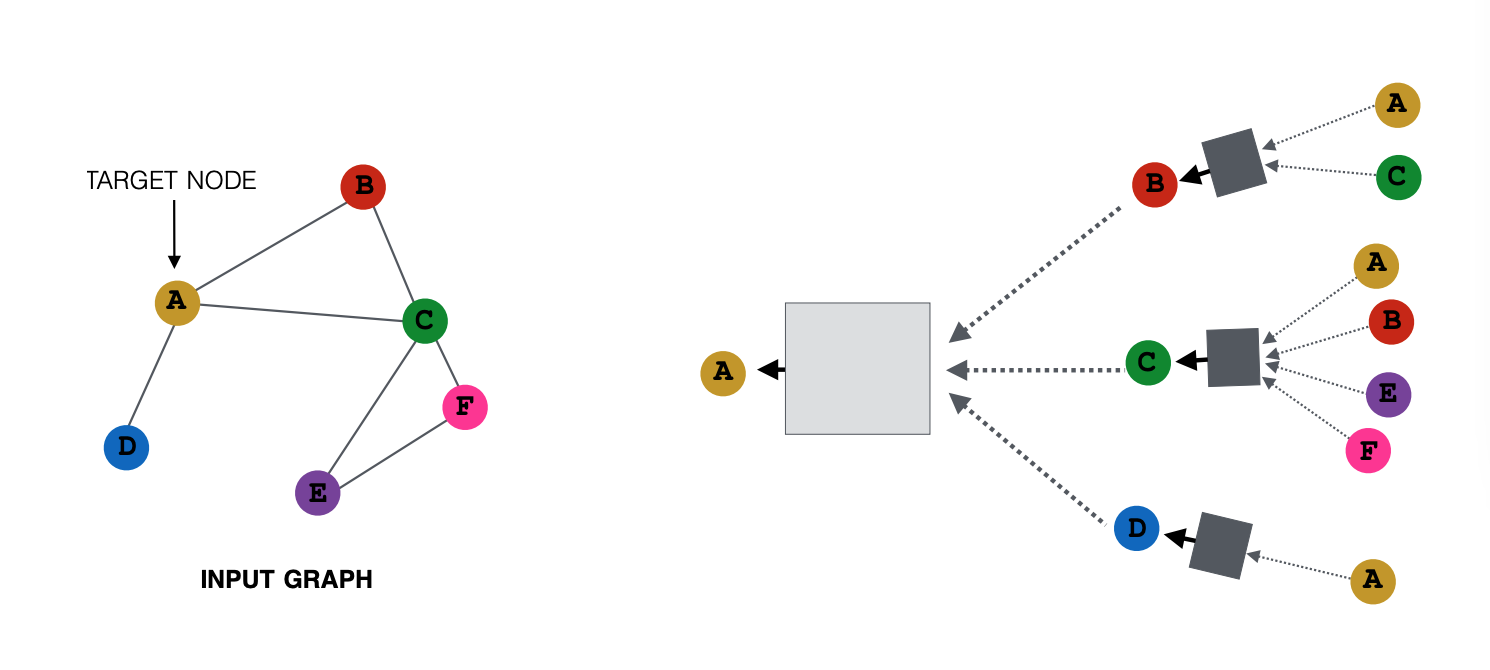

Note that this is only the view for node A. There are many more messages that are exchanged in the graph.
One such round is often also refered to as a **Graph Convolution**.

We can write down the steps of a single round as the following process:
Let $x_u^t$ be the state of node $u$ at time $t$.


$m^{t} = AGGREGATE(x_u^t, \{x_v | v \in N(u)\})$

the message $m$ at time $t$ is computed by the aggregation of the set of neighbors of $u$ and $u$.

$x_u^{t+1} = UPDATE(x_u^t, m^t)$

to compute the new state of node $u$ we take the previous state and the aggregated messages.

### Aggregation

A key question in the design of GNN models is to choose the aggregation function which defines how we can combine the different incoming messages from our neighbors. Note that the aggregate function takes as input a (multi)set of neighboring states $\{x_v \mid v \in N(u)\}$. How can we learn when we are given a set as input? We can reuse the techniques we have seen for DeepSet.




Recall, that we want to combine the messages in a special way, so that the order of the messages does not matter. This is also refered to as **permutation invariance**. The intuition behind this requirement is that we can not rely on a given enumeration or labeling of the nodes. Therefore, no matter in what order we process the messages, we should always compute the same outcome.

First, this might seem very restriciting, but you are already familiar with several permutation invariant aggregations.
One popular choice is to use the sum operation. Here all the incoming messages get summed up and no matter the ordering, the final sum will always be the same.

aggregation of $u$'s messages: $\sum_{v \in N(u)} x_v$

We can also quickly verify this ourselfs.

In [ ]:
def check_permutation(aggr, ):
  # create some random messages for us to check
  x = torch.rand((20,10))
  for i in range(20):
    x2=x[torch.randperm(x.size()[0])]
    if torch.norm(aggr(x2)-aggr(x)) > 0.0001:
      #print("not permutation invariant")
      return False
  #print("should be permutation invariant")
  return True


def sum_aggr(X):
  s = torch.zeros(10)
  for x in X:
    s += x
  return s

print(f"Sum aggregation is permuation invariant: {check_permutation(sum_aggr)}")

Can you find two aggregation functions that are permuatation invariant and one that is not?

In [ ]:
def perm_1(X):
  # TODO initialize a dummy value with all zeros
  s = torch.zeros(10) #change

  # TODO: combine the messages in a permutation invariant way
  for x in X:
    s *= x

  # return the aggregated value
  return s

def perm_2(X):
  # TODO initialize a dummy value with all zeros
  s = torch.zeros(10) #change

  # TODO: combine the messages in a permutation invariant way
  for x in X:
    s -= x

  # return the aggregated value
  return s

def not_perm(X):
  # initialize a dummy value with all zeros
  s = torch.zeros(10)

  # TODO: combine the messages so that they are NOT permuation invariant
  for x in X:
    s = x/2

  # return the aggregated value
  return s

In [ ]:
for f,s in [(perm_1, 'perm_1'), (perm_2, 'perm_2'), (not_perm, 'not_perm')]:
  if 'not' in s:
    if check_permutation(f):
      print(f"NO  {s} is permutation invariant, try again")
    else:
      print(f"YES  {s} is not invariant")
  else:
    if check_permutation(f):
      print(f"YES {s} is permutation invariant")
    else:
      print(f"NO  {s} is not yet invariant, try again")

For the $UPDATE$ step we could do something simple as just taking the computed messages. However, usually we compute the new state by combining the previous state and the message to a single tensor and put it through an MLP. This way we can let the GNN learn the UPDATE function.

##First GNN
Let's implement our first Graph Neural Network using a graph convolution called GIN ([paper](https://arxiv.org/pdf/1810.00826.pdf)). GIN uses sum aggregation and then has an MLP for the update step. The entire computation for a single convolution (round) is defined as:

$\displaystyle x_v^{(t+1)} = \Theta((1+\epsilon)\cdot x_v^{(t)} + \sum_{u \in N(v)} x_u^{(t)})$

where $x_v^{(t)}$ is the embedding of node $v$ at iteration $t$. In every iteration we execute the convolution synchronously for all nodes. For every node $v$, it aggreagates all neighboring states by summing them up and combines them with the old state of $v$ (using some learnable parameter $\epsilon$). The result is then passed through the MLP $\Theta$.
Let's see how to use this convolutional layer.

In [ ]:
import torch
import torch.nn.functional as F
    
# The GIN convolution itself is already implemented and ready to use
from torch_geometric.nn import GINConv

# A GNN looks very similar to any other neural network that we implement in pytorch
class GIN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # The MLP \Theta for our GIN convolution
        self.network1 = torch.nn.Sequential(torch.nn.Linear(1, 8), torch.nn.ReLU(), torch.nn.Linear(8, 2))

        # To define our GIN convolution, we have to pass the neural network \Theta that we want to use
        self.conv1 = GINConv(nn = self.network1)

    # We pass the data object that we previously introduced to the network
    def forward(self, data):
        # From it, we get the node features x and the edge index
        x, edge_index = data.x, data.edge_index

        # We pass x and edge_index to the convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Here we apply a log_softmax as we will use the return value for a NLLLoss
        return F.log_softmax(x, dim=1)

Now that we have our first GNN, let's use it on a dataset! The Tree dataset contains trees with leaf nodes marked as 1 and non-leaf nodes as 0 in the ground-truth. But first, we need some boilerplate code for our training loop. There is nothing unexpected here, we just run 20 epochs of training.

In [ ]:
import torch.optim as optim
from torch_geometric.loader import DataLoader

def train_model(model, dataset, epochs = 20):
  # define our loss and optimizer
  criterion = torch.nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)


  #prepare the data
  val_split = 0.8
  np.random.shuffle(dataset)
  train_size = int(val_split*len(dataset))
  train_loader = DataLoader(dataset[:train_size], batch_size=1, shuffle=True)

  # train the model
  model.train()

  for epoch in range(epochs):
      running_loss = 0.0
      for i, data in enumerate(train_loader):
          optimizer.zero_grad()

          # run the GNN
          data = data.to(device)
          pred = model(data)

          loss = criterion(pred, data.y.to(torch.long))
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      print(f'Epoch: {epoch + 1} loss: {running_loss / len(train_loader.dataset):.5f}')
      running_loss = 0.0

In [ ]:
# an example tree class for our first GNN
class Trees():
    def __init__(self):
        super().__init__()

    def gen_graph(self, num_nodes, num):
        nx_graph = nx.random_labeled_tree(n=num_nodes, seed=num)
        tree = from_networkx(nx_graph)
        leafs = [x for x in nx_graph.nodes() if nx_graph.degree(x)==1]
        tree.x = torch.ones(num_nodes, 1)
        tree.y = torch.zeros(num_nodes)
        for node in leafs:
            tree.y[node] = 1
        return tree

    def makedata(self, num_graphs = 200, num_nodes = 8):
        return [self.gen_graph(num_nodes, i) for i in range(num_graphs)]

In [ ]:
# Fix seeds for good measure
import random

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Use the tree dataset
dataset = Trees().makedata(num_graphs = 1000, num_nodes = 20)

model = GIN().to(device)
# Let's go!
train_model(model, dataset, epochs = 5)

The loss nicely decreases, indicating that our network learns to detect leafs in trees. Before continuing with the tutorial you should stop for a moment and reflect upon the dimensions for the neural networks that were chosen in the GNN. Why do they make sense? What is the size of the input, what is the output and how do they interact with each other?

## Cora prediction
The tree task was not particularly hard. Let's have a look at a second example, the Cora dataset. Cora consists of a graph where each node is a scientific paper and edges between the nodes correspond to citations between the different papers. The task is to classify what the subject of the paper is given some initial features and the citation graph.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

pytorch geometric already has the dataset setup, we can simply download it by executing the following.

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Next, we setup our GNN from before, we slightly adapt the number of in and out channels to match the format required by the cora dataset.

In [ ]:
import torch
import torch.nn.functional as F

# The GIN convolution itself is already implemented and ready to use
from torch_geometric.nn import GINConv

# A GNN looks very similar to any other neural network that we implement in pytorch
class GIN(torch.nn.Module):
    def __init__(self, in_channels = 16, out_channels = 7):
        super().__init__()

        # The MLP \Theta for our GIN convolution
        dim = 128
        self.network1 = torch.nn.Sequential(torch.nn.Linear(in_channels, dim), torch.nn.ReLU(), torch.nn.Linear(dim, out_channels))

        # To define our GIN convolution, we have to pass the neural network \Theta that we want to use
        self.conv1 = GINConv(nn = self.network1)

    # We pass the data object that we previously introduced to the network
    def forward(self, data):
        # From it, we get the node features x and the edge index
        x, edge_index = data.x, data.edge_index

        # We pass x and edge_index to the convolution
        x = self.conv1(x, edge_index)


        # Here we apply a log_softmax as we will use the return value for a NLLLoss
        return x

We can already instantiate our model (note that it is not trained yet) and look at the output it produces. This might take a minute or two in order to plot the beautiful picture of the citation graph.

In [ ]:
model = GIN(in_channels=1433 , out_channels = 7)
model.eval()

out = model(data)
visualize(out, color=data.y)

What is exactly displayed on this image? For each node in the graph, we compute it's embedding. Note that this embedding is very high dimensional and we can not directly plot it in the 2D plane. First, we use TSNE, which tries to figure out how the highdimensional points can be plotted in the 2D plane. The different colors represent the different subject areas of the papers. If our GNN learns a sensible representation of the nodes, we should be able to find a visualization that groups them together and we can see different areas in the 2D plane which correspond to different classes.


The different colors correspond to the different classes the GNN has to predict. It's not that surprising that this picture is a wild mix with no structure. The GNN has simply not seen the data before and was not trained on it. Therefore the embedding the GNN finds is more or less just random. Let's change that now.

In [ ]:
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc




model = GIN(in_channels=1433 , out_channels = 7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.04, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 5):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f} Test Accuracy: {test():.4f}')


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Let's have another look at what our model does, it is already better than just a random point cloud, but maybe we can improve it.
Try to play around with the size of the MLP that we define in the GIN model (you can adjust the parameter 'dim'). What do you observe?

In [ ]:
model.eval()

out = model(data)
visualize(out, color=data.y)

Now the 2D plot should look much better and you might see the "boundary" between different class predictions.

## Custom GNN

Until now we used the GIN convolution that is already provided by pytorch geometric. A nice comprehensive overview of all provided convolutions can be found here: [pytorch-geometric](https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html). Now what if we want to get more advanced and use our own convolution? In the following code snippet a new convolutional layer is defined.

What if we want to customize the way our message passing works? For example, when we create the message that we send, we might want to consider the neighbor we send it to. So instead of just sending our own state $x_i$ we can adjust the convolution to send a message that is dependent on $x_i$ and $x_j$. We do this by applying an MLP that takes $x_i, x_j$ and outputs the message.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import MessagePassing


# Our own Graph Convolution
# The secret is to use the MessagePassing class
class CustomMP(MessagePassing):
    def __init__(self, edge_nn, nn):
        # Here we can define how we want our aggregation function to look like. Out of the box we can use 'add','mean', 'max', ...
        super(CustomMP, self).__init__(aggr='mean')
        self.edge_nn = edge_nn
        self.nn = nn


    # This defines how our convolution updates the state
    def forward(self, x, edge_index):
      # self.propagate does the aggregation of incoming messages
      return x + self.nn(self.propagate(edge_index, x=x))



    # Before we send a message, we can customize it
    # access receiver x_i and sender x_j
    def message(self, x_j, x_i):
      # more elaborate example to look at both enpoints of an edge
      concatted = torch.cat((x_j, x_i), dim=1)
      return self.edge_nn(concatted)



# This is a GNN as before that uses the new convolutional layer
class AdvancedGNN(torch.nn.Module):
    def __init__(self, in_channels = 1433, out_channels = 7):
        super().__init__()

        dim = 8
        # define two MLP's, one to create the message and one to do the UPDATE
        self.network = torch.nn.Sequential(torch.nn.Linear(dim, dim), torch.nn.ReLU())
        self.edge_network = torch.nn.Sequential(torch.nn.Linear(2*dim, dim), torch.nn.ReLU() )

        # create our own custom graph convolution
        #TODO: initialize our Custom MP
        self.conv = CustomMP(
            edge_nn = None, #TODO,
            nn = None #TODO
        )

        # We usually use an encoder to map the input size to the size of the convolution
        self.encoder = torch.nn.Sequential(torch.nn.Linear(in_channels, dim), torch.nn.ReLU())
        # and a decoder to map the gnn output to the output size we expect
        self.decoder = torch.nn.Sequential(torch.nn.Linear(dim, out_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # apply encoder
        x = self.encoder(x)

        # apply graph convolutions
        x = self.conv(x, edge_index)

        # apply decoder
        x = self.decoder(x)

        # x should be logits for 2 classes
        return F.log_softmax(x, dim=1)


In [ ]:
print(AdvancedGNN())
# Fix seeds for good measure
import random

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Use the tree dataset
dataset = Trees().makedata(num_graphs = 1000, num_nodes = 20)

model = AdvancedGNN(1,2).to(device)
# Let's go!
train_model(model, dataset, epochs = 5)

Great! Now you know how you can adjust your own graph convolution, maybe try to use a different aggregation than mean. Does it train better now?

# Challenge: ESCAPE THE MAZE

All cells here are seperated for the purpose of clarifying the explanations of the individual code cells.

**There is a single cell that should be used for the submission.**


###Mazes

In this last block, you will solve a very practical task. How to find your way in a maze! First, let's look at the concrete task.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def create_dataset(size, num_mazes):
  images = []
  graphs = []
  x = []
  y = []
  for _ in range(num_mazes):
    G = nx.grid_2d_graph(size[0], size[1])
    for e in G.edges():
      G[e[0]][e[1]]['weight'] = random.uniform(0, 1)
    T = nx.minimum_spanning_tree(G)
    start, end = random.sample(list(T.nodes), k=2)
    path = nx.shortest_path(T, source=start, target=end)

    # Add graph
    #nx.set_node_attributes(T, ['blue' if n in [start, end] else 'green' for n in T.nodes], 'color')
    T.colors = ['blue' if n in [start, end] else 'green' for n in T.nodes]
    graphs.append(T)

    # Create images
    image = np.zeros((size[0]*2+1,size[1]*2+1))
    image_solution = np.zeros((size[0]*2+1,size[1]*2+1))
    for e in T.edges():
      image[e[0][0] + e[1][0] + 1][e[0][1] + e[1][1] + 1] = 1
      image_solution[e[0][0] + e[1][0] + 1][e[0][1] + e[1][1] + 1] = 1 if not (e[0] in path and e[1] in path) else 2
    for n in T.nodes():
      image[n[0]*2+1][n[1]*2+1] = 2 if n in [start, end] else 1
      image_solution[n[0]*2+1][n[1]*2+1] = 2 if n in [start, end] else (1 if not n in path else 2)
    images.append((F.one_hot(torch.tensor(image, dtype=torch.int64)), F.one_hot(torch.tensor(image_solution, dtype=torch.int64))))
    #x.append(F.one_hot(torch.tensor(image, dtype=torch.int64)))
    #y.append(F.one_hot(torch.tensor(image_solution, dtype=torch.int64)))
  return images, graphs

#@title
import torchvision

def show_graph_and_images(graph, images):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
  nx.draw(graphs[0], pos={node: (node[1], 4-node[0]) for node in graph.nodes}, node_color = graph.colors, ax=ax1)
  ax2.imshow(torchvision.transforms.ToPILImage()(images[0].permute(2, 0, 1).float()), interpolation="none")
  ax3.imshow(torchvision.transforms.ToPILImage()(images[1].permute(2, 0, 1).float()), interpolation="none")

We generate mazes on a grid of a fixed size and create two different versions of the same dataset. First, we can represent mazes as images. The input for the task are two points (pixels) in the maze that are marked with the same color. We have to find the (unique) path between these two points and mark them in the output. Instead of representing a maze as an image, we can also use graphs for this task. The next cell shows the graph representation of a maze, the according image to the right of it and the ground truth for the image.

In [ ]:
images, graphs = create_dataset((5, 4), 10)
show_graph_and_images(graphs[0], images[0])

Exercise: Create some larger mazes with the code above and plot the first datapoint


In [ ]:
# Generate and plot larger mazes:

#images, graphs = #TODO
images, graphs = create_dataset((20,20), 10) # REMOVE
# ...

### Setup
Now that you had a look at the dataset and the mazes we can think about how we want to design a GNN that can solve this task. First, we need to execute some cells to get a proper setup.

This cell generates the training dataset consisting of 200 4x4 mazes. You can ignore the specific code inside the cell.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

RATIO = 1

def create_dataset_graph(size, num_mazes, sizes = []):
  graphs = []
  counternodes = 0
  graphIDcounter = 0
  for num_mazes, size in sizes:
    def h(x):
      return x[1]+size[1]*x[0]
    for graphID in range(num_mazes):
      num_nodes = size[0]*size[1]
      G = nx.grid_2d_graph(size[0], size[1])
      for e in G.edges():
        G[e[0]][e[1]]['weight'] = random.uniform(0, 1)
      T = nx.minimum_spanning_tree(G)
      start, end = random.sample(list(T.nodes), k=2)
      path = nx.shortest_path(T, source=start, target=end)

      graph = from_networkx(T)
      graph.x = torch.zeros(num_nodes, 2)
      graph.x[:,1] = 1
      start = h(start)
      end = h(end)
      graph.x[start] = 1
      graph.x[start][1] = 0
      graph.x[end][0] = 1
      graph.x[end][1] = 0
      graph.y = torch.zeros(num_nodes)
      graph.ids = torch.zeros(num_nodes)
      graph.graphID = graphIDcounter
      for node in T.nodes:
        graph.ids[h(node)] = counternodes + h(node)
      for node in path:
        graph.y[h(node)] = 1
      graphs.append(graph)
      counternodes += num_nodes
      graphIDcounter += 1
  return graphs

And now we generate the graphs for the GNN Training.

In [ ]:
training_graphs = create_dataset_graph((4,4), 200, sizes = [(200,(4,4))])

We prepared a some evaluation functions for you already (you don't need to modify them yourself). Just run them ;)


In [ ]:
%%capture
! wget -O kaggle_data.pt https://polybox.ethz.ch/index.php/s/LUQIps4ZOYxfJeC/download

Function to evaluate the performance of GNN models on a given dataset. Used for evaluating and the validation set during training.

In [ ]:
from sklearn.metrics import f1_score

def eval_model_comp(model, dataset, mode = None):
  model.eval()
  acc = 0
  tot_nodes = 0
  tot_graphs = 0
  perf = 0
  gpred = []
  gsol = []

  # create a csv with the graph predictions
  csv_preds = []

  for step, batch in enumerate(dataset):
      n = len(batch.x)/batch.num_graphs
      with torch.no_grad():
        batch = batch.to(device)
        pred = model(batch, int(RATIO*n))

      if mode == "small":
        if n > 4*4:
          break
      elif mode == "medium":
        if n > 8*8:
          break
      elif mode == "large" or mode == "kaggle":
        if n > 16*16:
          break
      y_pred = torch.argmax(pred,dim=1)
      tot_nodes += len(batch.x)
      tot_graphs += batch.num_graphs


      if mode == "kaggle":
        #flatten y_pred into a string and then cast to integer
        # but instead of an array [1 0 0 1] we want a string "1001"
        csv_preds.append("".join([str(int(i)) for i in y_pred]))
        continue

      graph_acc = torch.sum(y_pred == batch.y).item()

      acc += graph_acc
      for p in y_pred:
        gpred.append(int(p.item()))
      for p in batch.y:
        gsol.append(int(p.item()))
      if graph_acc == n:
        perf += 1



  gpred = torch.tensor(gpred)
  gsol = torch.tensor(gsol)
  f1score = f1_score(gpred, gsol)
  acc = acc

  if mode == "kaggle":
    return (perf/tot_graphs, acc/tot_nodes, f1score), csv_preds

  return (perf/tot_graphs, acc/tot_nodes, f1score)

def eval_model(model, dataset, mode = None):
  if mode == "kaggle":
    stat, csv_preds = eval_model_comp(model, dataset, mode = mode)
    csv_path = 'gnn_challenge.csv'
    print("store predictions in gnn_challenge.csv ...")
    # write into a csv with "," as a delimiter
    with open(csv_path, 'w') as f:
      for line in csv_preds:
        f.write(line + '\n')
    a,b,c = stat
  else:
    a,b,c = eval_model_comp(model, dataset, mode = mode)
  return f"node accuracy: {b:.3f} | node f1 score: {c:.3f} | graph accuracy: {a:.3}"


def kaggle_eval(model, mode = None):
  print("Evaluating model on Challenge Data: ...")
  d = DataLoader(kaggle_dataset, batch_size = 1)
  return eval_model(maze_model, d, mode = "kaggle")


### Maze GNN
First, we have the setup for the training loop that you should now be very familiar with. We have the model, number of epochs and learning rate that we can adjust. For this task, we do not want to temper with the batch size, so just leave it at 1 (otherwise some functionalities might break down the road).


**The task**: for each node you have an input feature indicating wheter the node is one of the two endpoints. Our goal is to determine for each node if it is on the path between the two marked endpoints.


In [ ]:
import torch.optim as optim
from copy import deepcopy


def train_maze_model(model, epochs = 20):
    criterion = torch.nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0004)

    dataset = training_graphs
    val_split = 0.8

    #np.random.shuffle(dataset)
    train_size = int(val_split*len(dataset))
    train_loader = DataLoader(dataset[:train_size], batch_size=1, shuffle=True)
    val_set = DataLoader(dataset[train_size:], batch_size = 1)

    model.train()

    worst_loss = -1
    best_model = None


    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)


            # could change additional parameters here
            pred = model(data, data.num_nodes)

            loss = criterion(pred, data.y.to(torch.long))



            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()
        ss = eval_model(model, val_set)

        graph_val = float((ss.split(" ")[-1]))
        print(f'Epoch: {epoch + 1} loss: {running_loss / len(train_loader.dataset):.5f} \t {ss}')
        comp = (-graph_val, running_loss)
        if worst_loss == -1 or comp < worst_loss:
            worst_loss = comp
            best_model = deepcopy(model)
            print("store new best model", comp)

        running_loss = 0.0
    return best_model


Now after all these helper and setup cells .... we are finally ready to actually code our GNN!


We call this specific GNN the MazeGNN and furthermore we want to use our own custom convolution (the MazeConv). The skeleton provided here is very basic and you can change and customize it the way you want it to be. You might want to consider to include some of the tricks we have seen in the GNNs previously, such as including MLPs etc.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import MessagePassing

class MazeConv(MessagePassing):
    def __init__(self):
      super(MazeConv, self).__init__(aggr='add')
      #TODO
      #initialize custom message passing, store the MLP's for the convolution


    def forward(self, x, edge_index):
      #TODO
      #define own computation, call the round with
      #self.propagate(edge_index, x=x)
      x = x + self.propagate(edge_index, x = x)
      return x

    def message(self, x_j, x_i):
      #TODO
      #define the custom message that gnns exchange, x_i is own state, x_j is neighboring state
      return x_j


class MazeGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = 0.2

        hidden_dim = 8

        # we recommend using a larger dimension during the graph computation
        # therefore the encoder and decoder map in-/output to the used dimension
        self.encoder = self.get_mlp(2,8,hidden_dim)
        self.decoder = self.get_mlp(hidden_dim,32,2, last_relu = False)

        self.conv = MazeConv() # TODO you might want to add additional stuff here such as MLPs



    # get the graph and number of nodes in the graph
    def forward(self, data, num_nodes):
      #things to consider:
      # how many convolutions do we need to execute?
      # what kind of custom convolution could help

      x, edge_index = data.x, data.edge_index
      input = x

      x = self.encoder(x)

      #------------------------
      # Here you should specify the graph computations
      for i in range(2):
        x = self.conv(x, edge_index)

      #------------------------

      x = self.decoder(x)

      #output is logits of belonging to two classes
      return F.log_softmax(x, dim=1)


    # helper function - generates an MLP w. relu activation with 3 layers
    def get_mlp(self, input_dim, hidden_dim, output_dim, last_relu = True):
        modules = [torch.nn.Linear(input_dim, int(hidden_dim)), torch.nn.ReLU(), torch.nn.Dropout(self.dropout), torch.nn.Linear(int(hidden_dim), output_dim)]
        if last_relu:
            modules.append(torch.nn.ReLU())
        return torch.nn.Sequential(*modules)


You can execute the code below to train the model, for each epoch we plot the loss, the percentage of nodes whose labels (are they on the path or not)

In [ ]:
#set seeds for reproducability
seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# train the model
maze_model = MazeGNN().to(device)
train_maze_model(maze_model, epochs = 20)

### Local Evaluation

The test dataset contains 200 graphs of sizes 4x4, 8x8, 16x16 32x32 each

Note: we only want to train on small graphs, but during testing we also test on larger graphs.

The final score you should try to optimize is the F1 score on the medium Kaggle dataset.

In [ ]:
# mode ["all", "large", "medium", "small"]
kaggle_dataset = torch.load('kaggle_data.pt')
print(kaggle_eval(maze_model, mode = "medium"))

use `mode = "all"` to evaluate on all graphs

use `mode = "large"` to evaluate on all 16x16 graphs or smaller

use `mode = "medium"` to evaluate on all 8x8 graphs or smaller

use `mode = "small"` to evaluate on all 4x4 graphs

Things you might want to try in order to improve the GNN:



*   Add an MLP in the update step of the graph convolution (similar to the tasks we have seen before)
*   Add an MLP in the message step of the graph convolution and concatenate x_i, x_j (as seen before)
* Increase the number of convolutional layers
* Increase the number of training samples (a bit more than 200 might train better)


This should already increase performance by quite a bit on the small graphs.
For getting better performance on the larger graphs you might want to consider the following:
* Make the number of convolutional layers dependent on the number of nodes in the graph
* Before each graph convolution: concatenate the input and the x vector and put it through an MLP, this will help the GNN to remember the original input



Thanks for participating, we hope you have an aMAZEing time 😀

Have fun with the competition and may the best hodler get a hodlerone ;)

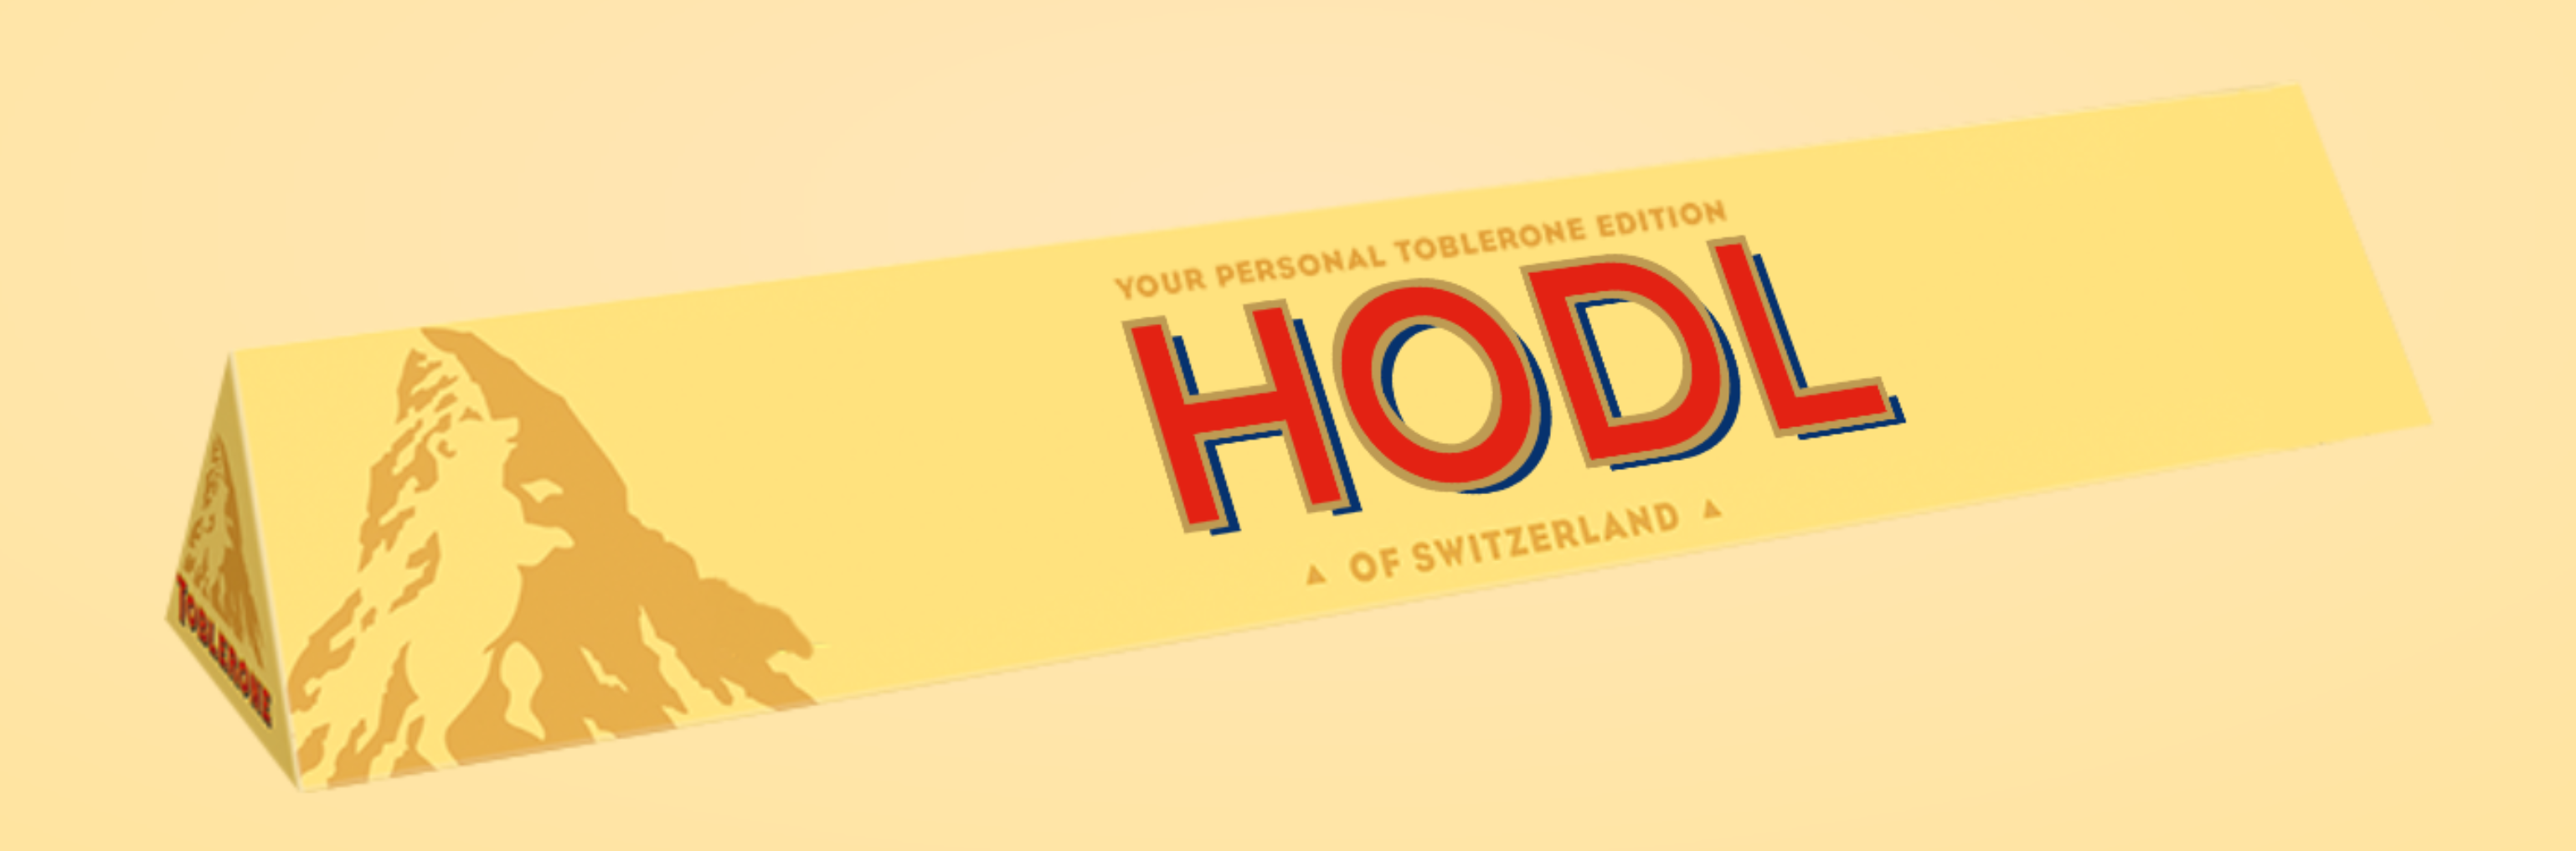

============================================================================


End of Google Colab Notebook

# Single Cell Submission

Try to optimize the F1 score for eval mode "medium".

The following cell should run independently (even after the notebook kernel was restarted) and produce the CSV for your challenge submission. The students with the three highest accuracy scores will win a prize.


In [ ]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)


! wget -O kaggle_data.pt https://polybox.ethz.ch/index.php/s/LUQIps4ZOYxfJeC/download


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")




import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import MessagePassing
from sklearn.metrics import f1_score
from torch_geometric.utils.convert import to_networkx, from_networkx
import torch.optim as optim
from torch_geometric.loader import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import f1_score
from copy import deepcopy


seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)



# ========================================================================================
# Utils
def eval_model_comp(model, dataset, mode = None):
  model.eval()
  acc = 0
  tot_nodes = 0
  tot_graphs = 0
  perf = 0
  gpred = []
  gsol = []

  # create a csv with the graph predictions
  csv_preds = []

  for step, batch in enumerate(dataset):
      n = len(batch.x)/batch.num_graphs
      with torch.no_grad():
        batch = batch.to(device)
        pred = model(batch, int(RATIO*n))

      if mode == "small":
        if n > 4*4:
          break
      elif mode == "medium":
        if n > 8*8:
          break
      elif mode == "large" or mode == "kaggle":
        if n > 16*16:
          break
      y_pred = torch.argmax(pred,dim=1)
      tot_nodes += len(batch.x)
      tot_graphs += batch.num_graphs


      if mode == "kaggle":
        #flatten y_pred into a string and then cast to integer
        # but instead of an array [1 0 0 1] we want a string "1001"
        csv_preds.append("".join([str(int(i)) for i in y_pred]))
        continue

      graph_acc = torch.sum(y_pred == batch.y).item()

      acc += graph_acc
      for p in y_pred:
        gpred.append(int(p.item()))
      for p in batch.y:
        gsol.append(int(p.item()))
      if graph_acc == n:
        perf += 1



  gpred = torch.tensor(gpred)
  gsol = torch.tensor(gsol)
  f1score = f1_score(gpred, gsol)
  acc = acc

  if mode == "kaggle":
    return (perf/tot_graphs, acc/tot_nodes, f1score), csv_preds

  return (perf/tot_graphs, acc/tot_nodes, f1score)

def eval_model(model, dataset, mode = None):
  if mode == "kaggle":
    stat, csv_preds = eval_model_comp(model, dataset, mode = mode)
    csv_path = 'gnn_challenge.csv'
    print("store predictions in gnn_challenge.csv ...")
    # write into a csv with "," as a delimiter
    with open(csv_path, 'w') as f:
      for line in csv_preds:
        f.write(line + '\n')
    a,b,c = stat
  else:
    a,b,c = eval_model_comp(model, dataset, mode = mode)
  return f"node accuracy: {b:.3f} | node f1 score: {c:.3f} | graph accuracy: {a:.3}"


def kaggle_eval(model, mode = None):
  print("Evaluating model on Challenge Data: ...")
  d = DataLoader(kaggle_dataset, batch_size = 1)
  return eval_model(maze_model, d, mode = "kaggle")




RATIO = 1

def create_dataset_graph(size, num_mazes, sizes = []):
  graphs = []
  counternodes = 0
  graphIDcounter = 0
  for num_mazes, size in sizes:
    def h(x):
      return x[1]+size[1]*x[0]
    for graphID in range(num_mazes):
      num_nodes = size[0]*size[1]
      G = nx.grid_2d_graph(size[0], size[1])
      for e in G.edges():
        G[e[0]][e[1]]['weight'] = random.uniform(0, 1)
      T = nx.minimum_spanning_tree(G)
      start, end = random.sample(list(T.nodes), k=2)
      path = nx.shortest_path(T, source=start, target=end)

      graph = from_networkx(T)
      graph.x = torch.zeros(num_nodes, 2)
      graph.x[:,1] = 1
      start = h(start)
      end = h(end)
      graph.x[start] = 1
      graph.x[start][1] = 0
      graph.x[end][0] = 1
      graph.x[end][1] = 0
      graph.y = torch.zeros(num_nodes)
      graph.ids = torch.zeros(num_nodes)
      graph.graphID = graphIDcounter
      for node in T.nodes:
        graph.ids[h(node)] = counternodes + h(node)
      for node in path:
        graph.y[h(node)] = 1
      graphs.append(graph)
      counternodes += num_nodes
      graphIDcounter += 1
  return graphs

training_graphs = create_dataset_graph((4,4), 200, sizes = [(200,(4,4))])

# ===================================================================================
# TRAIN

def train_maze_model(model, epochs = 20):
    criterion = torch.nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0004)

    dataset = training_graphs
    val_split = 0.8

    #np.random.shuffle(dataset)
    train_size = int(val_split*len(dataset))
    train_loader = DataLoader(dataset[:train_size], batch_size=1, shuffle=True)
    val_set = DataLoader(dataset[train_size:], batch_size = 1)

    model.train()

    worst_loss = -1
    best_model = None


    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)

            # could change additional parameters here
            pred = model(data, data.num_nodes)
            loss = criterion(pred, data.y.to(torch.long))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()
        ss = eval_model(model, val_set)

        graph_val = float((ss.split(" ")[-1]))
        print(f'Epoch: {epoch + 1} loss: {running_loss / len(train_loader.dataset):.5f} \t {ss}')
        comp = (-graph_val, running_loss)
        if worst_loss == -1 or comp < worst_loss:
            worst_loss = comp
            best_model = deepcopy(model)
            print("store new best model", comp)

        running_loss = 0.0
    return best_model
# ======================================================================================
# Model

class MazeConv(MessagePassing):
    def __init__(self):
      super(MazeConv, self).__init__(aggr='add')
      #TODO
      #initialize custom message passing, store the MLP's for the convolution


    def forward(self, x, edge_index):
      #TODO
      #define own computation, call the round with
      #self.propagate(edge_index, x=x)
      x = x + self.propagate(edge_index, x = x)
      return x

    def message(self, x_j, x_i):
      #TODO
      #define the custom message that gnns exchange, x_i is own state, x_j is neighboring state
      return x_j


class MazeGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = 0.2

        hidden_dim = 8

        # we recommend using a larger dimension during the graph computation
        # therefore the encoder and decoder map in-/output to the used dimension
        self.encoder = self.get_mlp(2,8,hidden_dim)
        self.decoder = self.get_mlp(hidden_dim,32,2, last_relu = False)

        self.conv = MazeConv() # TODO you might want to add additional stuff here such as MLPs



    # get the graph and number of nodes in the graph
    def forward(self, data, num_nodes):
      #things to consider:
      # how many convolutions do we need to execute?
      # what kind of custom convolution could help

      x, edge_index = data.x, data.edge_index
      input = x

      x = self.encoder(x)

      #------------------------
      # Here you should specify the graph computations
      for i in range(2):
        x = self.conv(x, edge_index)

      #------------------------

      x = self.decoder(x)

      #output is logits of belonging to two classes
      return F.log_softmax(x, dim=1)


    # helper function - generates an MLP w. relu activation with 3 layers
    def get_mlp(self, input_dim, hidden_dim, output_dim, last_relu = True):
        modules = [torch.nn.Linear(input_dim, int(hidden_dim)), torch.nn.ReLU(), torch.nn.Dropout(self.dropout), torch.nn.Linear(int(hidden_dim), output_dim)]
        if last_relu:
            modules.append(torch.nn.ReLU())
        return torch.nn.Sequential(*modules)


seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# train the model
maze_model = MazeGNN().to(device)
best_model = train_maze_model(maze_model, epochs = 2)


# ============================================ #
#         DO NOT CHANGE BELOW THIS LINE        #
# ============================================ #
# EVAL Results
kaggle_dataset = torch.load('kaggle_data.pt')
print(kaggle_eval(best_model))

This is a copy of the initial skeleton if you might want a fresh start ...

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import MessagePassing

class MazeConv(MessagePassing):
    def __init__(self):
      super(MazeConv, self).__init__(aggr='add')
      #TODO
      #initialize custom message passing, store the MLP's for the convolution


    def forward(self, x, edge_index):
      #TODO
      #define own computation, call the round with
      #self.propagate(edge_index, x=x)
      x = x + self.propagate(edge_index, x = x)
      return x

    def message(self, x_j, x_i):
      #TODO
      #define the custom message that gnns exchange, x_i is own state, x_j is neighboring state
      return x_j


class MazeGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = 0.2

        hidden_dim = 8

        # we recommend using a larger dimension during the graph computation
        # therefore the encoder and decoder map in-/output to the used dimension
        self.encoder = self.get_mlp(2,8,hidden_dim)
        self.decoder = self.get_mlp(hidden_dim,32,2, last_relu = False)

        self.conv = MazeConv() # TODO you might want to add additional stuff here such as MLPs



    # get the graph and number of nodes in the graph
    def forward(self, data, num_nodes):
      #things to consider:
      # how many convolutions do we need to execute?
      # what kind of custom convolution could help

      x, edge_index = data.x, data.edge_index
      input = x

      x = self.encoder(x)

      #------------------------
      # Here you should specify the graph computations
      for i in range(2):
        x = self.conv(x, edge_index)

      #------------------------

      x = self.decoder(x)

      #output is logits of belonging to two classes
      return F.log_softmax(x, dim=1)


    # helper function - generates an MLP w. relu activation with 3 layers
    def get_mlp(self, input_dim, hidden_dim, output_dim, last_relu = True):
        modules = [torch.nn.Linear(input_dim, int(hidden_dim)), torch.nn.ReLU(), torch.nn.Dropout(self.dropout), torch.nn.Linear(int(hidden_dim), output_dim)]
        if last_relu:
            modules.append(torch.nn.ReLU())
        return torch.nn.Sequential(*modules)
